In [9]:
import numpy as np

import matplotlib.pyplot as plt
from controllers import DeePC
import gym
from tqdm import tqdm
from IPython import display
import seaborn as sns
sns.set_theme()

plt.rcParams["figure.figsize"] = (15,8)

%matplotlib inline
%reload_ext autoreload
%autoreload 

## Data Collection

In [10]:
Tini = 1
N = 20
m = 1
p = 4
T = (m+1)*(Tini + N + p) + 10 

In [11]:
# env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')

# """
#     Timestep for InvertedPendelum-v4 is 0.02
# """

# obs, info = env.reset()
# print(T)
# render_collection = False

# ud = []
# yd = []
# i = 0

# while i < T:

#     # restart loop if data is non-linear
#     if np.abs(obs[1]) > 0.05 or np.abs(obs[0]) > 0.05 or np.abs(obs[2]) > 0.05 or np.abs(obs[3]) > 0.05 :
#         # print(i)
#         obs, info = env.reset()
#         i = 0
#         ud = []
#         yd = []

#     # Add noise to action and roll sim forward
#     action = [obs[1]*2 + np.random.randn()*0.01]
#     obs, rew, done, info, _ = env.step(action)
#     # obs += np.random.randn(p,)*0.01
#     ud = np.append(ud,action)
#     yd = np.append(yd,obs)

#     # display gym annimation if requested
#     if render_collection:
#         plt.title(f"Action {action[0]:.2f} Theta {obs[1]:.2f} Iter {i}")
#         plt.imshow(env.render())
#         display.display(plt.gcf())    
#         display.clear_output(wait=True)

#     i+=1

# env.close()
# print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')
# # yd += np.random.randn(T*p)*0.001

In [12]:
from numpy import genfromtxt
ud = genfromtxt('Ud.csv', delimiter=',')
yd = genfromtxt('Yd.csv', delimiter=',') #+ np.random.randn(T*p)*0.01
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

yd shape : (240,)   ud shape : (60,)


## Controller Setup

In [13]:
u_ini = ud[:m*Tini].reshape((Tini*m,))
y_ini = yd[:p*Tini].reshape((Tini*p,))
y_const = np.kron(np.ones(N), np.array([0.2, 20, 20, 20]))
u_const = np.ones(N)*3
R = np.eye(m)*1
Q = np.diag([100,100,100,100])

controller = DeePC(
    ud=ud, yd=yd, y_constraints=y_const, u_constraints=u_const,
    N=N, Tini=Tini, n=p, T=T, p=p, m=m
)

## Simulation

In [14]:
yT = [*y_ini]
uT = [*u_ini]
# ref = np.hstack([np.zeros((N-1)*p), np.array([0.,0.,0.,0.])])
ref = np.zeros(N*p)

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()
done = False
render = False
iter = 100
pbar = tqdm(range(0,iter))

for i in pbar:

    # Solve for optimal input
    controller.setup(ref=ref, u_ini=u_ini, y_ini=y_ini, Q=Q, R=R, lam_g1=100, lam_g2=100)
    action, _ = controller.solve(verbose=False)

    # roll simulation forward
    obs, _ ,done,_,_ = env.step(action)
    if done : break
    # obs += np.random.randn(p,)*0.01
    yT = np.append(yT, obs)
    uT = np.append(uT, action)
    
    # break from sim if constraints are violated
    # if np.abs(obs[1]) > 0.1 or np.abs(obs[0]) > 0.1 or np.abs(obs[2]) > 0.1 or np.abs(obs[3]) > 0.1 : break

    # Render gym env
    if render:
        plt.title(f"Action {action[0]:.4f}N, X {obs[0]:.3f}m, Theta {obs[1]:.3f} rad Iter {i}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    # Reset initial conditions
    u_ini = uT[-Tini:]
    y_ini = yT[-p*Tini:]


 82%|████████▏ | 82/100 [00:02<00:00, 33.18it/s]


KeyboardInterrupt: 

## Visualisation

In [ ]:
uT = uT[(Tini-1)*m:]
yT = yT[(Tini-1)*p:]
T = len(uT)
yT = yT.reshape((T,p))
uT = uT.reshape((T,m))

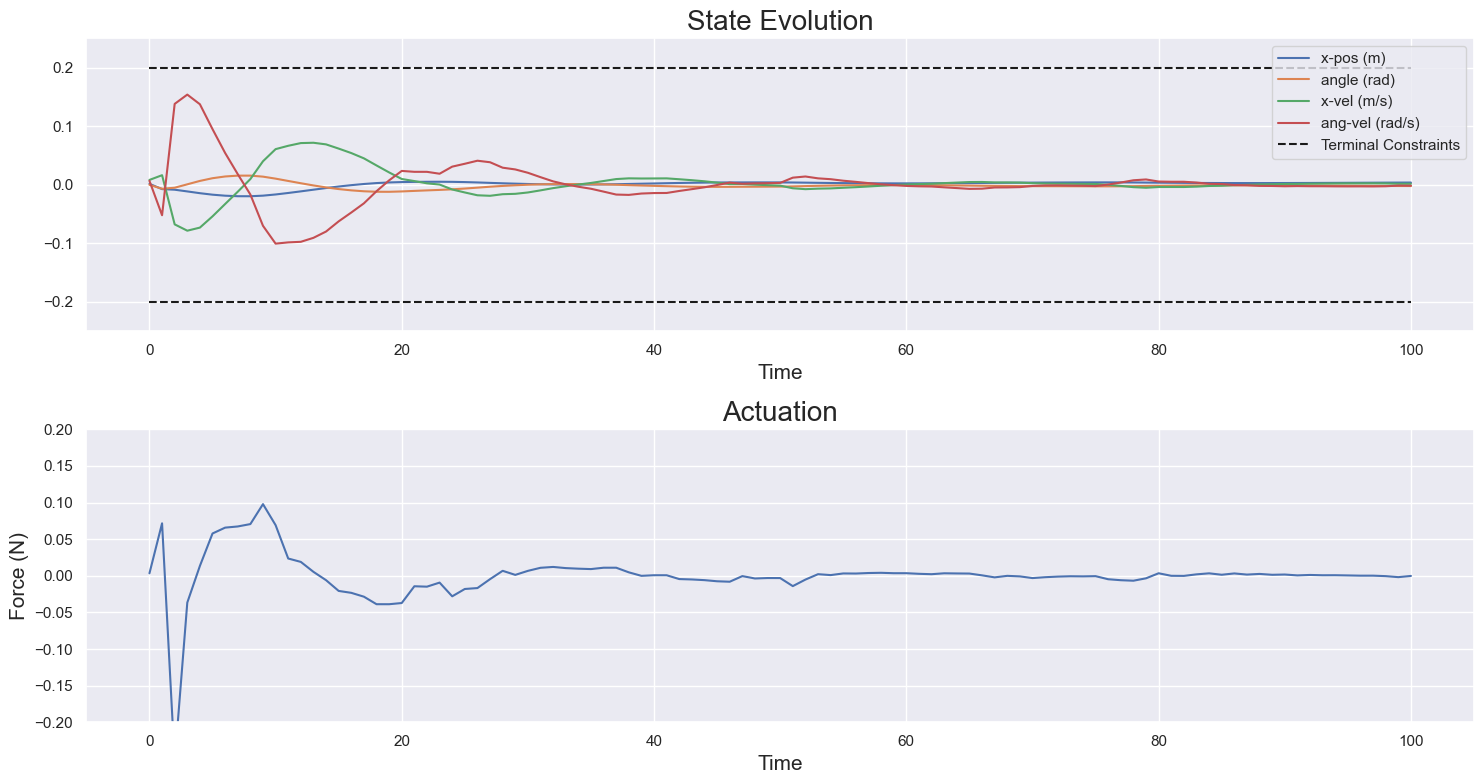

In [ ]:
plt.subplot(2,1,1)
plt.plot(range(0,T), yT, label=['x-pos (m)', 'angle (rad)', 'x-vel (m/s)', 'ang-vel (rad/s)'])
plt.plot(range(0,T), np.ones(T)*0.2, 'k--',label='Terminal Constraints')
plt.plot(range(0,T), -np.ones(T)*0.2, 'k--')
# plt.plot(range(0,T), np.ones(T)*0.05, 'r--',label='Constraints')
# plt.plot(range(0,T), -np.ones(T)*0.05, 'r--')
plt.legend(loc="upper right")
plt.ylim((-0.25,0.25))
plt.xlabel('Time', fontdict={'fontsize':15})
plt.title("State Evolution", fontdict={'fontsize':20})
plt.grid('on')
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(range(0,T), uT)
plt.ylabel('Force (N)', fontdict={'fontsize':15})
plt.xlabel('Time', fontdict={'fontsize':15})
plt.title("Actuation", fontdict={'fontsize':20})
plt.ylim((-0.2,0.2))
plt.grid('on')
plt.tight_layout()

plt.show()